In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../scripts')
import numerics
import cdd
import torch
from importlib import reload
import style
from os.path import join
import time
reload(numerics)

<module 'numerics' from '/home/davidclark/Projects/Subspace/paper-notebooks/../scripts/numerics.py'>

In [2]:
"""
Utilities
"""

def silence_region(T, i):
    Tp = T.copy()
    #Tp[i,:,:] = 0.
    Tp[:,i,:] = 0.
    #Tp[:,:,i] = 0.
    return Tp

def spect_T(T):
    P = T.shape[0]
    U = np.array([np.eye(P) for _ in range(P)])
    T_hat, U_hat = numerics.make_hat_vars(T, U)
    w = np.linalg.eigvals(T_hat)
    return w
    
def scatter_spect_T(T):
    w = spect_T(T)
    plt.scatter(w.real, w.imag, lw=0, s=10)
    plt.axvline(1, color='black', ls='--')
    plt.gca().set_aspect(1.)
    #plt.show()
    
def get_norm_Delta(Delta):
    P = Delta.shape[-1]
    diags = np.array([np.diag(Delta[..., i]) for i in range(P)])
    denom = np.sqrt(np.array([np.outer(diags[i], diags[i]) for i in range(P)]).T)
    return Delta / denom

In [3]:
"""
Generate T tensors that induce limit cycle transitions
"""

"""
P = 3
bad = True
while bad:
    seed = int((np.random.rand()*(2**32 - 1)))
    np.random.seed(seed)
    T = np.random.randn(P,P,P)*2/np.sqrt(P)
    w1 = spect_T(T)
    w2 = spect_T(silence_region(T, 0))
    d1 = w1[np.argmax(w1.real)]
    d2 = w2[np.argmax(w1.real)]
    if (np.abs(d1.imag) < 1e-6 and np.abs(d2.imag) > 0.01 and d1.real > 1 and d2.real > 1):
        #and d2.real > d1.real):
        bad = False
        print(seed)
"""

P = 3
special_T = []
np.random.seed(1302430346) #--> TRANSITION TO LIMITCYC FROM FP FOR G<1 W/ NO CHAOS
T = np.random.randn(P,P,P)*2/np.sqrt(P)
special_T.append(T)
np.random.seed(3276071239) #--> TRANSITION TO LIMITCYC FROM FP FOR G>1 W/ CHAOS+FP BETWEEN
T = np.random.randn(P,P,P)*2/np.sqrt(P)
special_T.append(T)
special_T = np.array(special_T)

In [4]:
"""
Run analysis for each T tensor for a range of g0 vals
"""

g_0_vals = np.arange(0.3, 3.3, 0.3)
U = np.array([np.eye(P) for _ in range(P)])

def run_analysis():
    all_slices = np.zeros((len(g_0_vals), 2, 2, 1500, 3)) #g, T_idx, Dvs.D_n, 1500, P
    all_S = np.zeros((len(g_0_vals), 2, 3000, 3, 3))
    all_psi = np.zeros((len(g_0_vals), 2, 3000, 3))
    for g_0_idx in range(len(g_0_vals)):
        g_0 = g_0_vals[g_0_idx]

        g_vals = np.zeros(P)
        g_vals[0] = g_0

        for T_idx in range(2):
            print(g_0_idx, T_idx)
            T = special_T[T_idx]
            t1 = time.time()
            Delta, S, psi, H = numerics.run_ns_dmft_multi_pop(
                Nt=3000, dt=0.05, U=U, T=T, g_vals=g_vals)
            t2 = time.time()
            print(t2-t1)
            Delta_n = get_norm_Delta(Delta)
            m = len(Delta)//2
            D_slice = np.array([np.roll(Delta[m,:,i], -m)[:m] for i in range(P)]).T
            D_n_slice = np.array([np.roll(Delta_n[m,:,i], -m)[:m] for i in range(P)]).T
            
            all_slices[g_0_idx, T_idx, 0] = D_slice
            all_slices[g_0_idx, T_idx, 1] = D_n_slice
            all_S[g_0_idx, T_idx] = S
            all_psi[g_0_idx, T_idx] = psi

            np.savez("lc_demo_data_3.npz", all_slices=all_slices, all_S=all_S, all_psi=all_psi)

#run_analysis()
data = np.load("lc_demo_data_3.npz")
all_slices = data['all_slices']
all_S = data['all_S']
all_psi = data['all_psi']

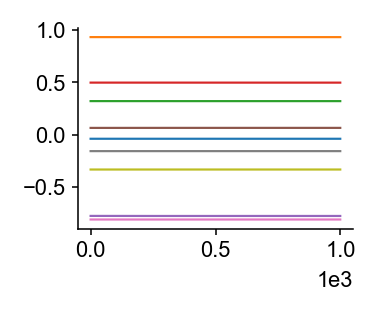

In [5]:
T_idx = 0
g_0_idxs = [0, 1, 4, 8] if T_idx == 0 else [1, 4, 6, 8]

S = all_S[g_0_idxs[0], T_idx]
S = S.reshape(len(S), -1)
plt.plot(S[2000:])

In [7]:
"""
Plotting stuff
"""

fig_width = 3.375
fig_height = 3.375*1.6

fig_vpad_mid = 0.1
subfig_height = (fig_height-fig_vpad_mid)/2. #(fig_width-fig_tpad-fig_bpad) / 2.

lpad = 0.085
rpad = 0.015
tpad = 0.11
bpad = 0.15
vpad_left = 0.1
left_height = (1-tpad-vpad_left-bpad)/2.
left_width = left_height*subfig_height/fig_width
hpad_lr = 0.125
hpad_small = 0.035
vpad_small = 0.12

N_right = 4
small_width = (1-lpad-left_width-hpad_lr-(N_right-1)*hpad_small-rpad)/N_right
small_height = (1-tpad-3*vpad_small-bpad)/4.

def make_axes_double():
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=120)
    subfigs = fig.subfigures(3, 1, hspace=0., height_ratios=[subfig_height,fig_vpad_mid,subfig_height])
    subfigs = [subfigs[0], subfigs[2]]
    
    all_axes = []
    for fig_ in subfigs:
        ax1 = fig_.add_axes((lpad, bpad+left_height+vpad_left, left_width, left_height))
        ax2 = fig_.add_axes((lpad, bpad, left_width, left_height))
        axes = [ax1, ax2]
        for i in range(N_right):
            xcord = lpad+left_width+hpad_lr+(small_width+hpad_small)*i
            ax_l = fig_.add_axes((xcord, bpad, small_width, small_height))
            ax_m = fig_.add_axes((xcord, bpad+small_height+vpad_small, small_width, small_height))
            ax_u = fig_.add_axes((xcord, bpad+2*(small_height+vpad_small), small_width, small_height))
            ax_uu = fig_.add_axes((xcord, bpad+3*(small_height+vpad_small), small_width, small_height))
            axes += [ax_uu, ax_u, ax_m, ax_l]
        all_axes.append(axes)

    return fig, all_axes

def make_axes_single():
    fig = plt.figure(figsize=(fig_width, subfig_height), dpi=120)
    axes = []
    ax1 = fig.add_axes((lpad, bpad+left_height+vpad_left, left_width, left_height))
    #ax2 = fig_.add_axes((lpad, bpad, left_width, left_height))
    axes = [ax1,]
    for i in range(N_right):
        xcord = lpad+left_width+hpad_lr+(small_width+hpad_small)*i
        ax_l = fig.add_axes((xcord, bpad, small_width, small_height))
        ax_m = fig.add_axes((xcord, bpad+small_height+vpad_small, small_width, small_height))
        ax_u = fig.add_axes((xcord, bpad+2*(small_height+vpad_small), small_width, small_height))
        axes += [ax_u, ax_m, ax_l]
    return axes


In [8]:
colors = ['tab:blue', 'tab:orange', 'tab:green', '0.25', '0.5']
colors_shaded = [
    '#bcd6e9',  # Lightest tab:blue
    '#79add2',  # Lighter tab:blue
    '#1f77b4',  # Original tab:blue
    '#ffd9b7',  # Lightest tab:orange
    '#ffb26e',  # Lighter tab:orange
    '#ff7f0e',  # Original tab:orange
    '#c0e3c0',  # Lightest tab:green
    '#80c680',  # Lighter tab:green
    '#2ca02c'   # Original tab:green
]

def plot_spect(T, ax, xlabel=True):
    w = spect_T(T)
    ax.scatter(w.real, w.imag, lw=0, s=10, clip_on=False, color='black')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.vlines(x=1, color='black', ls='--', ymin=-2, ymax=1.7)
    if xlabel: ax.set_xlabel("Re$\lambda$")
    ax.set_ylabel("Im$\lambda$", labelpad=-1)

def plot_delta(deltas, ax, ylabel=True):
    t = np.arange(len(deltas))*0.05
    ax.axhline(1.,ls='--',c='black', clip_on=False)
    ax.axhline(0.,ls='--',c='black', clip_on=False)
    for i in range(deltas.shape[1]):
        ax.plot(t, deltas[:,i], clip_on=False, color=colors[i])
    ax.set_ylim(-1, 1)
    ax.set_xticks([0, 50])
    ax.set_xlim(0, 50)
    ax.set_xlabel("$\\tau$", labelpad=-2.5)
    if not ylabel:
        ax.set_yticklabels([])
    if ylabel: ax.set_ylabel("$\Delta^{\mu}(\\tau)$", labelpad=0)
    
def plot_psi(psi, ax, ylabel=True):
    t = np.arange(len(psi))*0.05
    for i in range(psi.shape[1]):
        ax.plot(t, psi[:,i], clip_on=False, color=colors[i])
    ax.set_ylim(0, 1)
    ax.set_xlabel("$t$", labelpad=-2.5)
    ax.set_xticks([0, 50])
    ax.set_xlim(0, 50)
    ax.axhline(1., c='black', ls='--', zorder=0, clip_on=False)
    if not ylabel:
        ax.set_yticklabels([])
    if ylabel: ax.set_ylabel("$\psi^{\mu}(t)$")
        
def plot_S(S, ax, ylabel=True):
    S = S.reshape(len(S), -1)
    t = np.arange(len(S))*0.05
    for i in range(S.shape[1]):
        ax.plot(t, S[:,i], clip_on=False, color=colors_shaded[i])
    #ax.set_ylim(0, 1)
    ax.set_xlabel("$t$", labelpad=-2.5)
    ax.set_xticks([0, 50])
    ax.set_xlim(0, 50)
    #ax.axhline(1., c='black', ls='--', zorder=0, clip_on=False)
    if not ylabel:
        ax.set_yticklabels([])
    if ylabel: ax.set_ylabel("$S^{\mu \\nu}(t)$")
    ax.set_ylim(-1.5, 1.5)
    ax.set_yticks([-1, 1])
    
def plot_spect_dynamics(T, psi, ax, ylabel=True):
    Tt = np.einsum('mnr,tn->tmnr', T, psi)
    all_w = np.array([spect_T(Tt[t_idx]) for t_idx in range(0, len(psi), 20)])
    for i in range(all_w.shape[1]): #25 evals
        ax.scatter(all_w[:,i].real, all_w[:,i].imag, lw=0, s=1.5, color='black',
                  clip_on=False)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-1, 1)
    #ax.set_aspect(1.)
    ax.axvline(1., ls='--', color='black', zorder=0)
    ax.set_xlabel("Re$\lambda$")
    if not ylabel:
        ax.set_yticklabels([])
    if ylabel: ax.set_ylabel("Im$\lambda$", labelpad=-1)

    

Text(0.35, 0.15650000000000008, '(e.ii)')

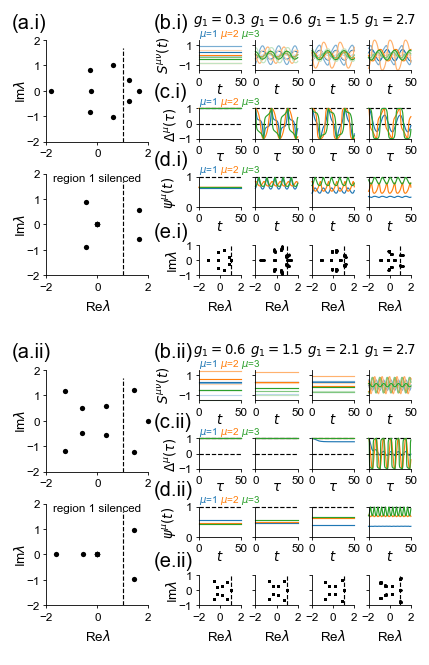

In [9]:
def draw_mus(ax):
    ax.text(0, 1, s="$\\mu$=1", c='tab:blue',
              va='bottom', ha='left', size=6, clip_on=False, transform=ax.transAxes)
    ax.text(0.5, 1, s="$\\mu$=2", c='tab:orange',
              va='bottom', ha='left', size=6, clip_on=False, transform=ax.transAxes)
    ax.text(1, 1, s="$\\mu$=3", c='tab:green',
              va='bottom', ha='left', size=6, clip_on=False, transform=ax.transAxes)

fig, all_axes = make_axes_double()
for T_idx in range(2):
    axes = all_axes[T_idx]
    T = special_T[T_idx]
    plot_spect(T, axes[0], xlabel=False)
    plot_spect(silence_region(T, 0), axes[1])
    axes[1].text(0.5, 1, 'region 1 silenced', ha='center', va='top', transform=axes[1].transAxes, size=7)
    
    g_0_idxs = [0, 1, 4, 8] if T_idx == 0 else [1, 4, 6, 8]
    for i in range(4):
        ax_uu, ax_u, ax_m, ax_l = axes[2+4*i : 2+4*(i+1)]
        g_0_idx = g_0_idxs[i]
        g_0 = g_0_vals[g_0_idx]
        
        #plot S
        S = all_S[g_0_idx, T_idx, 2000:] #last 50 s
        plot_S(S, ax_uu, ylabel=(i==0))
        ax_uu.set_title("$g_1 = {}$".format(np.round(g_0, 2)), pad=10)
        
        #plot Delta_hat
        deltas = all_slices[g_0_idx, T_idx, 1, :1000] #first 50 s
        plot_delta(deltas, ax_u, ylabel=(i==0))
        if i == 0:
            draw_mus(ax_uu)
            draw_mus(ax_u)
            draw_mus(ax_m)
        
        #plot psi
        psi = all_psi[g_0_idx, T_idx, 2000:] #last 50 s
        plot_psi(psi, ax_m, ylabel=(i==0))
        
        #plot spect
        T = special_T[T_idx]
        psi = all_psi[g_0_idx, T_idx, 2000:] #last 50 s
        plot_spect_dynamics(T, psi, ax_l, ylabel=(i==0))
        
        
fig.text(0, 0.9875, "(a.i)", size=12, va='top', ha='left')
fig.text(0.35, 0.9875, "(b.i)", size=12, va='top', ha='left') 
fig.text(0.35, 0.88, "(c.i)", size=12, va='top', ha='left')
fig.text(0.35, 0.775, "(d.i)", size=12, va='top', ha='left')
fig.text(0.35, 0.665, "(e.i)", size=12, va='top', ha='left')

X = 0.5085
fig.text(0, 0.9875 - X, "(a.ii)", size=12, va='top', ha='left')
fig.text(0.35, 0.9875 - X, "(b.ii)", size=12, va='top', ha='left') 
fig.text(0.35, 0.88 - X, "(c.ii)", size=12, va='top', ha='left')
fig.text(0.35, 0.775 - X, "(d.ii)", size=12, va='top', ha='left')
fig.text(0.35, 0.665 - X, "(e.ii)", size=12, va='top', ha='left')

#fig.text(0, 1, "(a)", size=12, va='top', ha='left') 

#plt.savefig('../figs/shaping_dynamics.pdf')


In [10]:
"""
5 POP EXAMPLE
make tensor...
"""

P = 5
np.random.seed(43)
T = np.random.randn(P,P,P)*3.5/np.sqrt(P)

"""
Run analysis
"""

g_vals = np.array([0.,1.,2.,3.])
U = np.array([np.eye(P) for _ in range(P)])
all_acov = np.zeros((len(g_vals), 1250, 5))
all_psi = np.zeros((len(g_vals), 2500, 5))

def run_analysis():
    for g_idx in range(len(g_vals)):
        print(g_idx)
        g = g_vals[g_idx]
        Delta, S, psi, H = numerics.run_ns_dmft_multi_pop(
            Nt=2500, dt=0.05, U=U, T=T, g_vals=np.ones(P)*g)
        Delta_n = get_norm_Delta(Delta)
        m = len(Delta)//2
        for i in range(P):
            D = np.roll(Delta_n[m, :, i], -m)[:m]
            all_acov[g_idx, :, i] = D
        all_psi[g_idx] = psi
        np.savez("p5_cache_2.npz",
                 g_vals=g_vals, all_acov=all_acov, all_psi=all_psi)

data = np.load("p5_cache_2.npz")
g_vals, all_acov, all_psi = [data[k] for k in ("g_vals", "all_acov", "all_psi")]


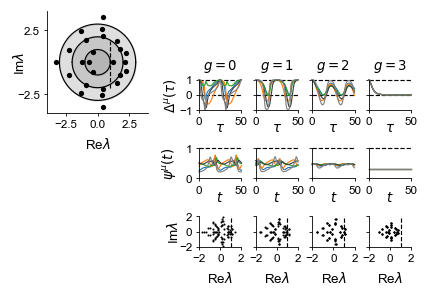

In [12]:
axes = make_axes_single()

ax = axes[0]
plot_spect(T=T, ax=ax)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
for r in g_vals[1:]:
    x = np.linspace(-r, r, 1000)
    y = np.sqrt(r**2 - x**2)
    ax.fill_between(x, -y, y, color='gray', alpha=0.25, zorder=0)
    ax.plot(x, -y, color='black')
    ax.plot(x, y, color='black')
ax.set_ylabel("Im$\lambda$", labelpad=-6)
ax.set_yticks([-2.5, 2.5])

for i in range(4):
    ax_u, ax_m, ax_l = axes[1+i*3:1+(i+1)*3]
    plot_delta(all_acov[i,:1000], ax_u, ylabel=(i==0))
    ax_u.set_title("$g={}$".format(int(g_vals[i])))
    psi = all_psi[i,-1000:]
    plot_psi(psi, ax_m, ylabel=(i==0))
    plot_spect_dynamics(T=T, psi=psi[::20], ax=ax_l, ylabel=(i==0))
    ax_l.set_xlim(-2, 2)
    ax_l.set_ylim(-2, 2)
    
#plt.savefig("../figs/five_pop.pdf")